In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

In [3]:
iija = pd.read_csv('iija.csv')
iija['State, Teritory or Tribal Nation'] = iija['State, Teritory or Tribal Nation'].str.lower()
iija = iija.rename(columns = {iija.columns[0]:'State'})
iija.loc[iija['State']=='us virgin islands', 'State'] = 'u.s. virgin islands'
iija.loc[iija['State']=='deleware', 'State'] = 'delaware'

In [4]:
population = pd.read_csv('state_pop.csv')
population['State'] = population['State'].replace(r'\.', '', regex=True).str.lower()
population = population[5:].reset_index().drop(columns = ['index'])

In [5]:
elections = pd.read_csv('state_election_results.csv', skiprows=[1, 2])

elections = elections.set_axis(list(elections.iloc[0]),axis = 1)

elections = elections.iloc[1:]

elections.columns = ['State_Abbrev', 'Biden Electoral', 'Trump Electoral', 'Biden Popular', 'Trump Popular', 'All Others', 'Total Vote']

elections['State_Abbrev'] = elections['State_Abbrev'].replace(r'\*', '', regex=True)

In [6]:
# URL of the webpage
url = "https://www.britannica.com/topic/U-S-state-and-territory-abbreviations-2229773"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all tables in the HTML
    tables = soup.find_all('table')

    # Check if any tables are found
    if tables:
        # Assume the desired table is the first one (change index if needed)
        target_table = tables[0]

        # Use Pandas to read the HTML table into a DataFrame
        df = pd.read_html(str(target_table))[0]
    else:
        print("No tables found on the webpage.")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")

state_abbrev = df

state_abbrev['U.S. state or territory'] = state_abbrev['U.S. state or territory'].str.lower()

state_abbrev = state_abbrev.rename(columns = {state_abbrev.columns[0]:'State', state_abbrev.columns[1]:'State_Abbrev'})

state_abbrev = state_abbrev[['State','State_Abbrev']]

In [7]:
# URL of the webpage
url = "https://fred.stlouisfed.org/release/tables?eid=257197&rid=110"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all tables in the HTML
    tables = soup.find_all('table')

    # Check if any tables are found
    if tables:
        # Assume the desired table is the first one (change index if needed)
        target_table = tables[0]

        # Use Pandas to read the HTML table into a DataFrame
        df = pd.read_html(str(target_table))[0]
        
    else:
        print("No tables found on the webpage.")
else:
    print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
    
gdp = df

gdp = gdp.drop(gdp.columns[[0, 3, 4]], axis=1)

gdp.columns = gdp.columns.droplevel()

gdp = gdp.rename(columns = {gdp.columns[0]:'State', gdp.columns[1]:'2022 GDP'})

gdp['State'] = gdp['State'].str.lower()

In [411]:
#state_abbrev.head()

In [150]:
#iija.head()

In [140]:
#elections.head()

In [141]:
#population.head()

In [8]:
elections_w_abbrev = pd.merge(elections, state_abbrev, on='State_Abbrev', how='outer')

elections_iija = pd.merge(iija, elections_w_abbrev, on='State', how='outer')

df = pd.merge(population, elections_iija, on='State', how='outer')

df = pd.merge(df, gdp, on='State', how = 'outer')

df = df.drop([57])

df = df.rename(columns = {'Total (Billions)':'iija funding'})

df.head()

,State,2020,2021,2022,2023,iija funding,State_Abbrev,Biden Electoral,Trump Electoral,Biden Popular,Trump Popular,All Others,Total Vote,2022 GDP
0,alabama,"5,031,864","5,050,380","5,073,903","5,108,468",3.0,AL,NaN,9,"849,624","1,441,170","32,488","2,323,282",50916.0
1,alaska,"732,964","734,923","733,276","733,406",3.7,AK,NaN,3,"153,778","189,951","15,801","359,530",68635.0
2,arizona,"7,186,683","7,272,487","7,365,684","7,431,344",3.5,AZ,11,NaN,"1,672,143","1,661,686","53,497","3,387,326",58442.0
3,arkansas,"3,014,348","3,028,443","3,046,404","3,067,732",2.8,AR,NaN,6,"423,932","760,647","34,490","1,219,069",52618.0
4,california,"39,503,200","39,145,060","39,040,616","38,965,193",18.4,CA,55,NaN,"11,110,639","6,006,518","384,223","17,501,380",77036.0


In [25]:
territories = {'guam':172952, 
               'u.s. virgin islands': 98750,
               'puerto rico': 3260314, 
               'northern mariana islands': 49796,
               'american samoa': 43914}

for state, number in territories.items():
    df.loc[df['State'] == state, '2023'] = number

In [10]:
columns_to_process = ['2020', '2021', '2022', '2023', 'Biden Popular', 'Trump Popular', 'All Others','Total Vote']

df[columns_to_process] = df[columns_to_process].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce'))

df['biden_%'] = df['Biden Popular'] / df['Total Vote']

df['trump_%'] = df['Trump Popular'] / df['Total Vote']

In [11]:
conditions = [
    (~df['Biden Electoral'].isna()),
    (~df['Trump Electoral'].isna()),
    (df['Biden Electoral'].isna())&(df['Trump Electoral'].isna())
]

values = ['Biden', 'Trump', 'No General Election']

# Create a new column based on conditions
df['Winner'] = np.select(conditions, values, default='Unknown')

In [26]:
df['iija funding per capita'] = (df['iija funding'] / df['2023']) * 1000000000

In [13]:
df.head()

,State,2020,2021,2022,2023,iija funding,State_Abbrev,Biden Electoral,Trump Electoral,Biden Popular,Trump Popular,All Others,Total Vote,2022 GDP,biden_%,trump_%,Winner,iija funding per capita
0,alabama,5031864.0,5050380.0,5073903.0,5108468.0,3.0,AL,NaN,9,849624.0,1441170.0,32488.0,2323282.0,50916.0,0.365700,0.620316,Trump,587.260212
1,alaska,732964.0,734923.0,733276.0,733406.0,3.7,AK,NaN,3,153778.0,189951.0,15801.0,359530.0,68635.0,0.427720,0.528331,Trump,5044.954636
2,arizona,7186683.0,7272487.0,7365684.0,7431344.0,3.5,AZ,11,NaN,1672143.0,1661686.0,53497.0,3387326.0,58442.0,0.493647,0.490560,Biden,470.978063
3,arkansas,3014348.0,3028443.0,3046404.0,3067732.0,2.8,AR,NaN,6,423932.0,760647.0,34490.0,1219069.0,52618.0,0.347751,0.623957,Trump,912.726405
4,california,39503200.0,39145060.0,39040616.0,38965193.0,18.4,CA,55,NaN,11110639.0,6006518.0,384223.0,17501380.0,77036.0,0.634844,0.343203,Biden,472.216319


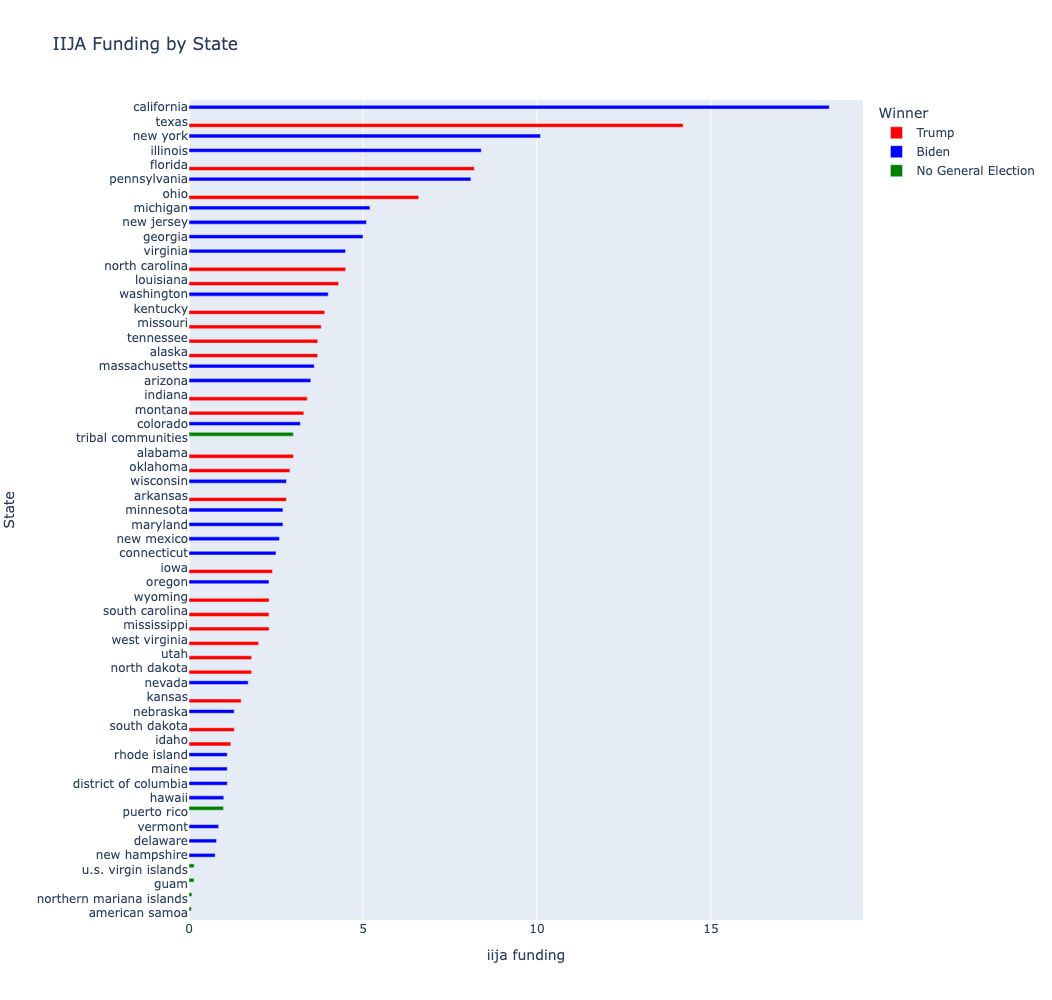

In [27]:
color_map = {'Biden':'blue','Trump':'red','No General Election':'green'}

fig = px.bar(df, x="iija funding", y="State", color='Winner', 
             title='IIJA Funding by State',
            color_discrete_map=color_map)

fig.update_layout(width=800, height=1000,
    barmode='group',  # or 'stack' depending on your preference
    yaxis_categoryorder='total ascending')

fig.show()

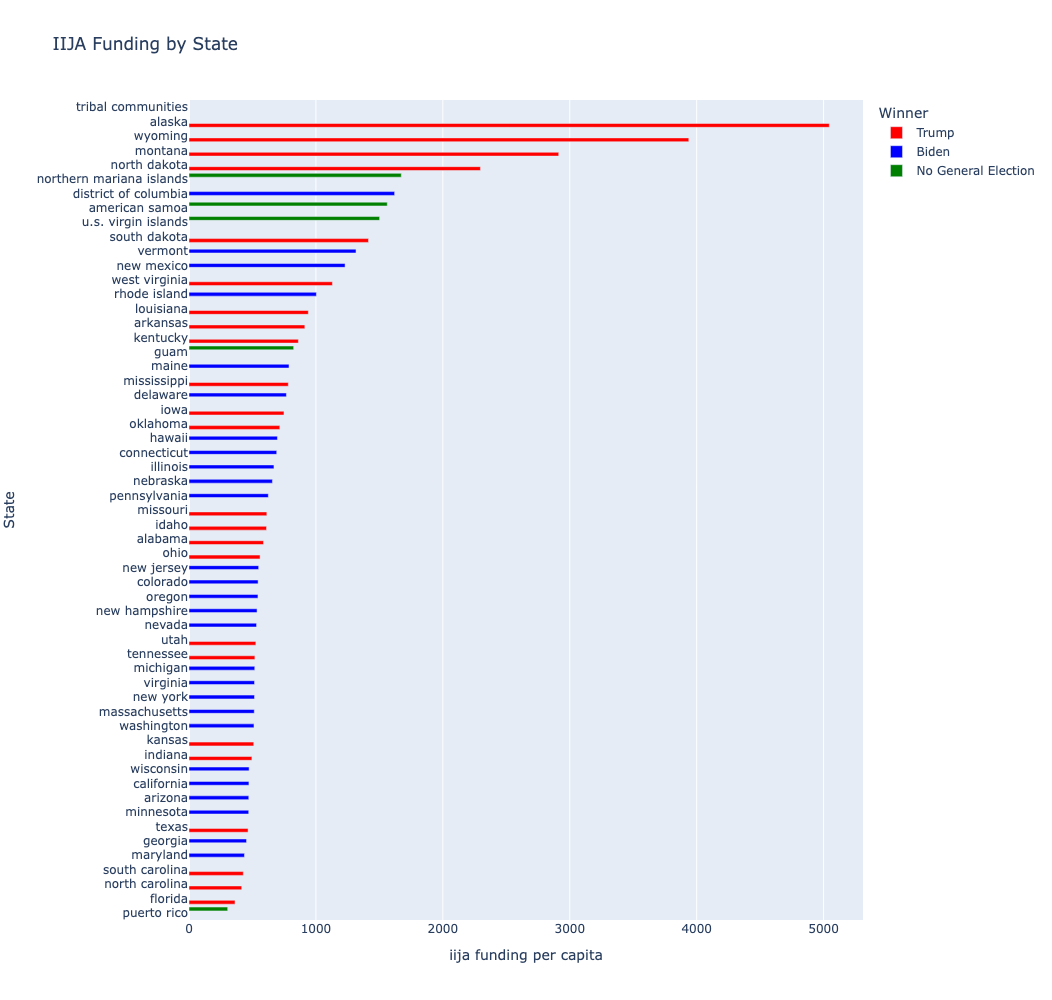

In [28]:
color_map = {'Biden':'blue','Trump':'red','No General Election':'green'}

fig = px.bar(df, x="iija funding per capita", y="State", color='Winner',
             title='IIJA Funding by State',
            color_discrete_map=color_map)

fig.update_layout(width=800, height=1000,
    barmode='group',  # or 'stack' depending on your preference
    yaxis_categoryorder='total ascending')

fig.show()

In [21]:
# aggregation by winner with sums for iija funding and populations of state a certain candidate won
df1 = df.groupby('Winner')[['iija funding', '2023', '2022 GDP']].sum().reset_index()

df1['iija funding per capita'] = (df1['iija funding']/df1['2023']) * 1000000000

df1.head()

,Winner,iija funding,2023,2022 GDP,iija funding per capita
0,Biden,104.3959,191897826.0,1844900.0,544.018148
1,No General Election,4.4365,3625726.0,0.0,1223.617008
2,Trump,87.2000,143017069.0,1412066.0,609.717432


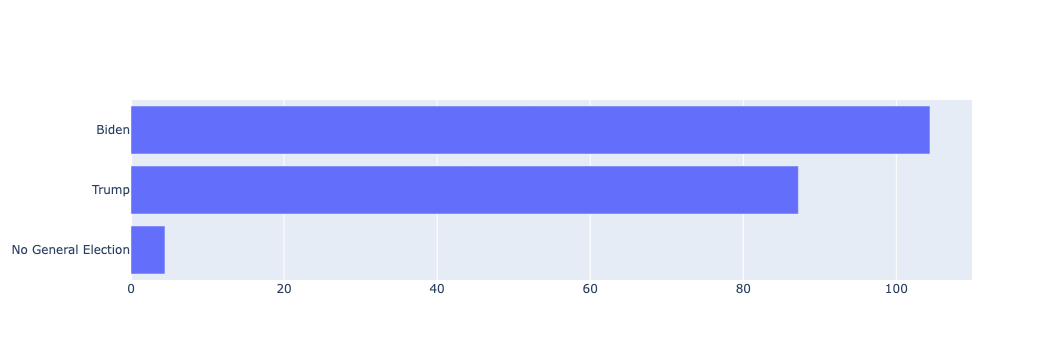

In [22]:
fig = go.Figure(go.Bar(
            x=df1["iija funding"], y=df1["Winner"],
            orientation='h'))

fig.update_layout(
    barmode='group',  # or 'stack' depending on your preference
    yaxis_categoryorder='total ascending')

fig.show()

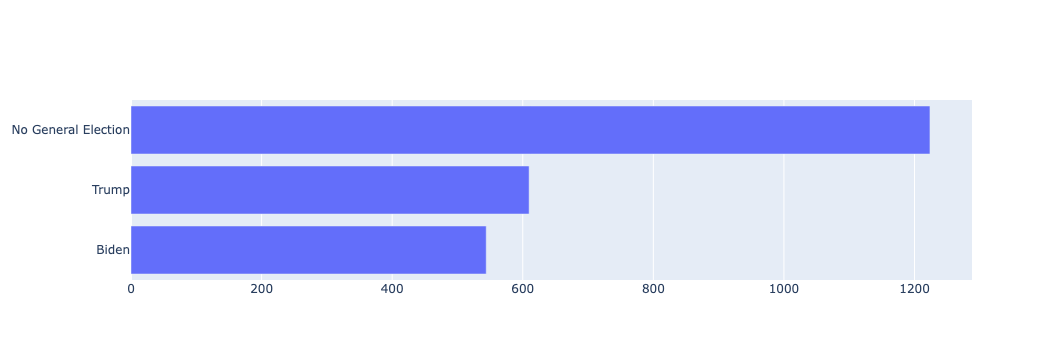

In [23]:
df1['iija funding per capita'] = (df1['iija funding']/df1['2023']) * 1000000000

fig = go.Figure(go.Bar(
            x=df1["iija funding per capita"], y=df1["Winner"],
            orientation='h'))

fig.update_layout(
    barmode='group',  # or 'stack' depending on your preference
    yaxis_categoryorder='total ascending')

fig.show()